In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
SCRIPT_PATH='.'
module_path = os.path.abspath(os.path.join(SCRIPT_PATH))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from utils import load_county_case_data, load_patient_data, get_delay_onset_confirmation_probabilities
from utils import prepare_county_cases, adjust_onset_for_right_censorship, confirmed_to_onset
from utils import create_and_run_model_for_counties, df_from_model, reparametrize
from utils import agg_cases_to_state_level, aggregate_results, plot_rt, prepare_cases, load_daily_state_cases
from utils import compute_mean_kinsa_atypical_illness, compute_delay_onset_confirmation_probabilities, compute_adjusted_cases
from utils import read_google_mobility_data

In [5]:
mobility = read_google_mobility_data()

In [6]:
mobility.head()

,state_name,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,countyFIPS
0,all US,statewide,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0,all US,NaN
1,all US,statewide,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0,all US,NaN
2,all US,statewide,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0,all US,NaN
3,all US,statewide,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0,all US,NaN
4,all US,statewide,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0,all US,NaN


In [8]:
mobility.state_name.unique()

array(['all US', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [9]:
state = mobility[mobility.state_name == "New York"]

In [40]:
state.head()

,state_name,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,countyFIPS
132151,New York,statewide,2020-02-15,3.0,-4.0,-2.0,-4.0,1.0,0.0,NY,NaN
132152,New York,statewide,2020-02-16,7.0,-3.0,13.0,0.0,0.0,-1.0,NY,NaN
132153,New York,statewide,2020-02-17,7.0,-2.0,23.0,-22.0,-37.0,9.0,NY,NaN
132154,New York,statewide,2020-02-18,-2.0,-5.0,-4.0,-5.0,-10.0,3.0,NY,NaN
132155,New York,statewide,2020-02-19,3.0,-2.0,11.0,-3.0,-9.0,2.0,NY,NaN


In [ ]:
transit_state = state[]

In [17]:
rolling = state["transit_stations_percent_change_from_baseline"].rolling(7,
                                 win_type='gaussian',
                                 min_periods=1,
                                 center=True).mean(std=2).round()

In [43]:
state.iloc[:200, :]

,state_name,county,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,state,countyFIPS
132151,New York,statewide,2020-02-15,3.0,-4.0,-2.0,-4.0,1.0,0.0,NY,NaN
132152,New York,statewide,2020-02-16,7.0,-3.0,13.0,0.0,0.0,-1.0,NY,NaN
132153,New York,statewide,2020-02-17,7.0,-2.0,23.0,-22.0,-37.0,9.0,NY,NaN
132154,New York,statewide,2020-02-18,-2.0,-5.0,-4.0,-5.0,-10.0,3.0,NY,NaN
132155,New York,statewide,2020-02-19,3.0,-2.0,11.0,-3.0,-9.0,2.0,NY,NaN
...,...,...,...,...,...,...,...,...,...,...,...
132346,New York,Allegany County,2020-03-11,8.0,9.0,NaN,NaN,-2.0,-1.0,NY,36003.0
132347,New York,Allegany County,2020-03-12,16.0,18.0,NaN,NaN,-1.0,-1.0,NY,36003.0
132348,New York,Allegany County,2020-03-13,10.0,15.0,NaN,NaN,-7.0,2.0,NY,36003.0
132349,New York,Allegany County,2020-03-14,16.0,18.0,NaN,NaN,4.0,NaN,NY,36003.0


In [30]:
state["date"].head()

132151   2020-02-15
132152   2020-02-16
132153   2020-02-17
132154   2020-02-18
132155   2020-02-19
Name: date, dtype: datetime64[ns]

In [31]:
state["date"].tail()

137416   2020-05-05
137417   2020-05-06
137418   2020-05-07
137419   2020-05-08
137420   2020-05-09
Name: date, dtype: datetime64[ns]

In [38]:
rolling.dropna()

132151    -7.0
132152    -7.0
132153    -7.0
132154    -7.0
132155    -6.0
          ... 
137249   -59.0
137250   -57.0
137251   -55.0
137252   -54.0
137253   -49.0
Name: transit_stations_percent_change_from_baseline, Length: 3247, dtype: float64

In [39]:
len(rolling)

5270

In [28]:
sroll = rolling.values[:1000]

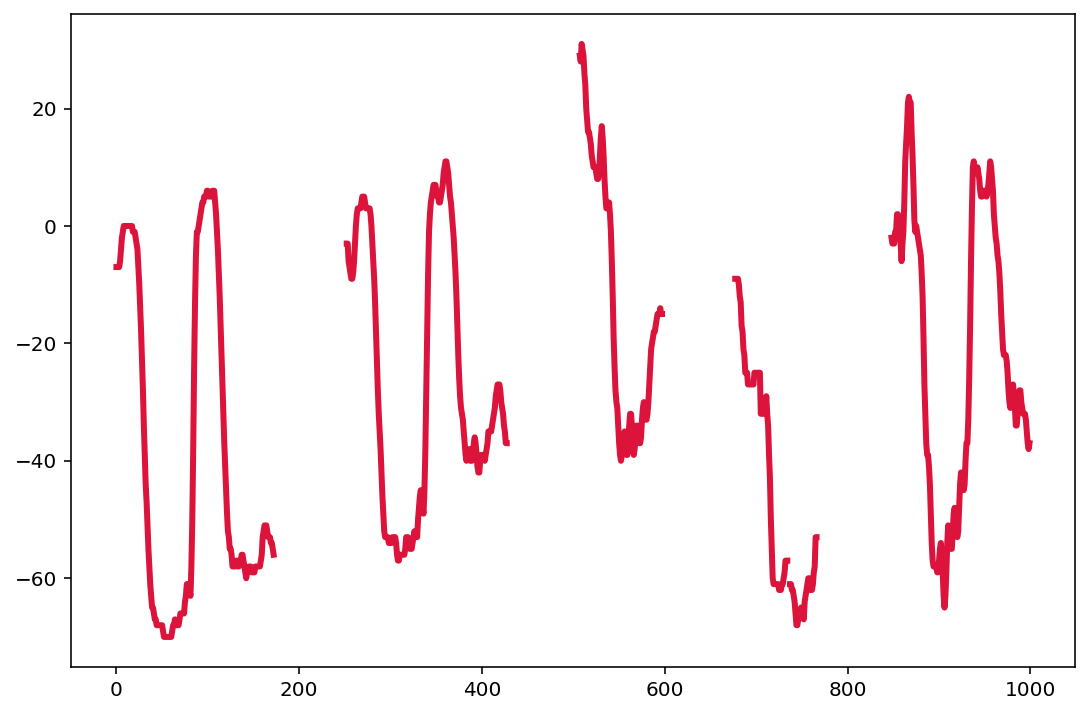

In [29]:
figure, ax = plt.subplots(figsize=(9, 6))
ax.plot(np.arange(len(sroll)), sroll, lw=3, color="crimson")
plt.show()
plt.close()